In [1]:
import os

import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
f = gzip.GzipFile(r"../../Data/rBergomiTrainSet.txt.gz", "r")
dat=np.load(f)
xx=dat[:,:4]
yy=dat[:,4:]
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


x_train, x_test, y_train, y_test = train_test_split(
    xx, yy, test_size=0.15, random_state=42)

In [3]:
def append_and_expand(a,x,y):
    # use choose and where !
    n = len(x)*len(y)
    a_index = np.arange(len(a))%n
    
    
    x_index = a_index//len(y)
    y_index = a_index%len(y)
    
    x_added = np.choose(x_index,x.reshape(-1,1)).reshape(-1,1)
    y_added = np.choose(y_index,y.reshape(-1,1)).reshape(-1,1)
    
    return np.hstack([a,x_added,y_added])

y_train,y_test = y_train.reshape(-1,8,11),y_test.reshape(-1,8,11)
x_train,x_test = np.repeat(x_train, 8*11,axis=0),np.repeat(x_test, 8*11,axis=0)

In [4]:
x_train,x_test=append_and_expand(x_train,maturities,strikes),append_and_expand(x_test,maturities,strikes)
y_train,y_test = y_train.reshape(-1).reshape(-1,1), y_test.reshape(-1).reshape(-1,1)

In [5]:
import torch
import torch.nn as nn

scale_y=  StandardScaler()

def ytransform(y_train,y_test):
    return [scale_y.fit_transform(y_train),scale_y.transform(y_test)]

def yinversetransform(y):
    return scale_y.inverse_transform(y)

# Upper and lower bounds used in the training set
ub=np.array([0.16,4,-0.1,0.5,2.0,1.5])
lb=np.array([0.01,0.3,-0.95,0.025,0.1,0.5])

def myscale(x):
    return (x - (ub+lb)*0.5)*2/(ub-lb)
def myinverse(x):
    return x*(ub-lb)*0.5+(ub+lb)*0.5

x_train_transform = myscale(x_train)
x_test_transform = myscale(x_test)
[y_train_transform,y_test_transform] = ytransform(y_train,y_test)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"device is {device}")

train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_train_transform).to(device=device),
                                               torch.from_numpy(y_train_transform).to(device=device))
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_test_transform).to(device=device),
                                              torch.from_numpy(y_test_transform).to(device=device))


train_data = (torch.from_numpy(x_train_transform).to(device=device),torch.from_numpy(y_train_transform).to(device=device))
test_data = (torch.from_numpy(x_test_transform).to(device=device),torch.from_numpy(y_test_transform).to(device=device))

data_loader = torch.utils.data.DataLoader(train_dataset,batch_size =88,shuffle=False)

device is cuda


In [6]:
import sys
sys.path.append('../../')  # Add the parent directory to the Python path

from torch_NN.nn import ResNN_pricing

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

hyperparas = {'input_dim':6,'hidden_dim':32,'hidden_nums':2,'output_dim':1,'block_layer_nums':2}

model = ResNN_pricing(hyperparas=hyperparas).to(device=device,dtype=torch.float64)
loss_MSE = nn.MSELoss()
optim_Adam = torch.optim.Adam(model.parameters(),lr= 0.001)

-----------------------Epoch: 0----------------------------------
Batch: 0,train loss is: 0.9350224465108343
test loss is 1.3191236531097355
Batch: 100,train loss is: 0.7585126332330467
test loss is 0.32679044017801256
Batch: 200,train loss is: 0.06201622496455958
test loss is 0.19031348747907373
Batch: 300,train loss is: 0.04291416440674622
test loss is 0.13472471227986357
Batch: 400,train loss is: 0.04940528915663738
test loss is 0.1013333044831383
Batch: 500,train loss is: 0.020549839171460017
test loss is 0.08798405824986696
Batch: 600,train loss is: 0.031676135806809606
test loss is 0.07191770857499215
Batch: 700,train loss is: 0.024122471756715388
test loss is 0.06357153232637401
Batch: 800,train loss is: 0.024270533555906616
test loss is 0.05510518458235628
Batch: 900,train loss is: 0.06214446048635984
test loss is 0.05024927521385726
Batch: 1000,train loss is: 0.017333781559597212
test loss is 0.042812890559569716
Batch: 1100,train loss is: 0.15995411735969653
test loss is 0.03

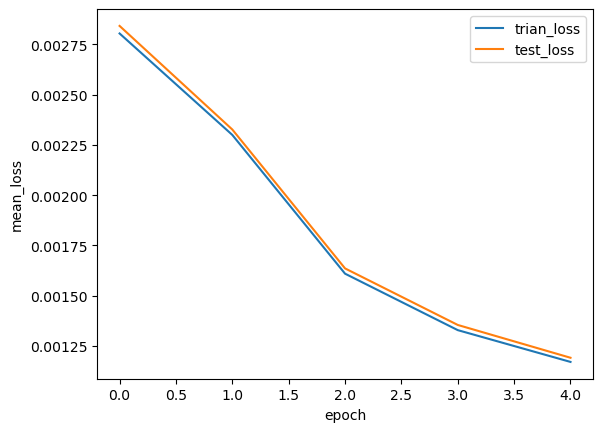

In [7]:
from torch_NN.train import train_model

train_model(loss_MSE,optim_Adam,model,data_loader,train_data,test_data,5)

-----------------------Epoch: 0----------------------------------
Batch: 0,train loss is: 0.0008136041264781578
test loss is 0.0011932262283353896
Batch: 100,train loss is: 0.001177657869277787
test loss is 0.000990759981233816
Batch: 200,train loss is: 0.001137975048906528
test loss is 0.0009580303860115736
Batch: 300,train loss is: 0.0004379209369922525
test loss is 0.0009443038470637811
Batch: 400,train loss is: 0.0006911707509453032
test loss is 0.0009344677015693903
Batch: 500,train loss is: 0.0006914656152541721
test loss is 0.0009509406976755326
Batch: 600,train loss is: 0.00048419083537505847
test loss is 0.0009339807337114542
Batch: 700,train loss is: 0.00039259703752652915
test loss is 0.0009292155195822973
Batch: 800,train loss is: 0.0005510201491311479
test loss is 0.0009114298281759286
Batch: 900,train loss is: 0.00043729376710663364
test loss is 0.0009086317323654068
Batch: 1000,train loss is: 0.0006141154500695981
test loss is 0.0009204128226695306
Batch: 1100,train loss

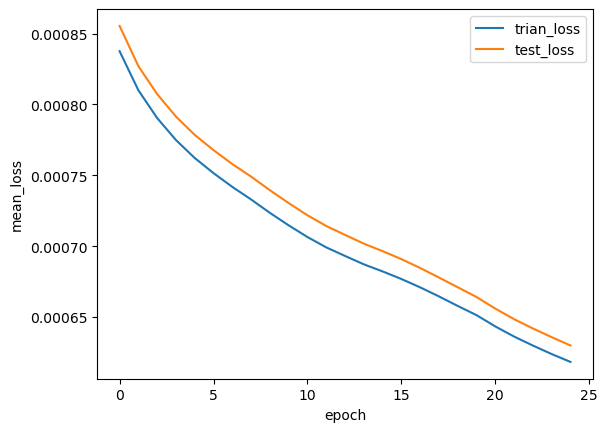

In [8]:
for param_group in optim_Adam.param_groups:
    param_group['lr'] = 0.0001

train_model(loss_MSE,optim_Adam,model,data_loader,train_data,test_data,25)

In [10]:
torch.save(model.state_dict(),'../restruct_data_results/rflatBergomi_pointwise88_4-layer.pth')